In [1]:
import pandas as pd

data = pd.read_excel('data/Сводный отчет за декабрь.xlsx', header=1)

In [2]:
if 'Название ККТ' in data.columns:
    # выберем данные с одной точки
    data = data[data['Название ККТ'] == 'ТРЦ "Фокус"']
    # выберем только данные прихода
    data = data[data['Тип операции'] == 'Приход']
    data['День'] = data['Дата и время'].apply(lambda x: x.day)

    data.drop(columns=['Тип операции', 'Наличными', 'Безналичными', 'Название ККТ', 'Дата и время'], inplace=True)
data = data.groupby(['День']).sum()
data.reset_index(inplace=True)
data.head()

,День,Сумма
0,1,590.0
1,2,19900.0
2,3,16200.0
3,4,2570.0
4,5,7330.0


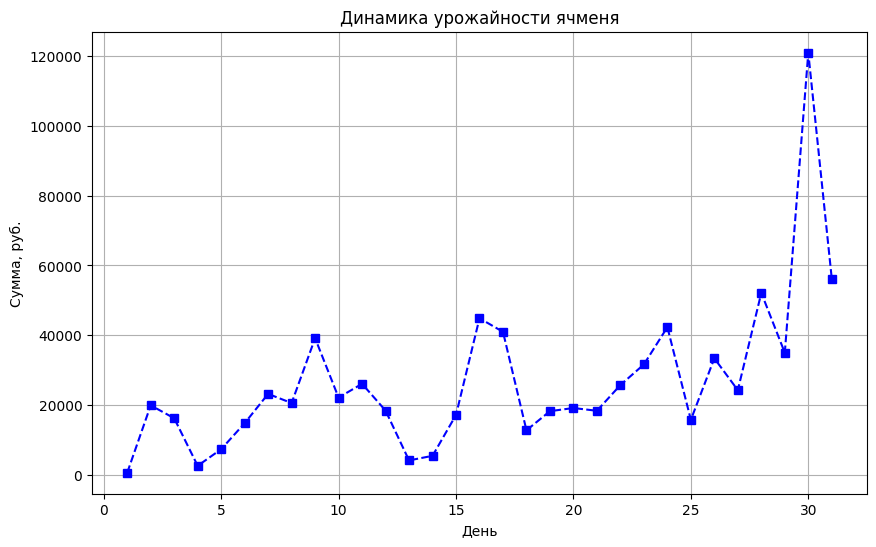

In [3]:
import matplotlib.pyplot as plt
data_column = 'Сумма'
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data['День'], data[data_column], '--bs')
plt.title('Динамика урожайности ячменя')
plt.xlabel('День')
plt.ylabel('Сумма, руб.')
plt.grid(True)
plt.show()

# Критерий серий, основанный на медиане


In [25]:
median_yield = data[data_column].median()
print(f'медиана = {median_yield}')

# Определение серий: значения выше или ниже медианы
above_median = data[data_column] > median_yield
series = above_median.ne(above_median.shift()).cumsum()
series_counts = series.value_counts()

# Количество серий
num_series = len(series_counts)
print(f'Количество серий = {num_series}')

# Нахождение длины каждой серии
series_lengths = series.map(series.value_counts())

# Нахождение максимальной длины серии
max_series_length = series_lengths.max()
print(f'Максимальная длина серии = {max_series_length:.2f}')

from math import sqrt, log10

n = len(data[data_column])
first_equel = int(1/2*(n+2-1.96*sqrt(n-1)))

second_equel = int((log10(n) + 1) * 3.3)
first_equel, second_equel

print(f'\nКол-во серий должно быть меньше {first_equel:.2f}\n'
     f'Максимальная длина серии долдна быть меньше {second_equel:.2f}')

if num_series > first_equel and max_series_length < second_equel:
  print('Ни одно из неравенств не нарушено. => тренда нет'
        '\n  Гипотеза о неизменности среднего значения временного ряда не отвергается с вероятностью ошибки 0,05')
else:
  print('Как минимум одно неравенство было нарушено! => '
        '\n  Гипотеза о неизменности среднего значения временного ряда отвергается с вероятностью ошибки 0,05')

медиана = 20550.0
Количество серий = 10
Максимальная длина серии = 6.00

Кол-во серий должно быть меньше 11.00
Максимальная длина серии долдна быть меньше 8.00
Как минимум одно неравенство было нарушено! => 
  Гипотеза о неизменности среднего значения временного ряда отвергается с вероятностью ошибки 0,05


# Критерий «восходящих» и «нисходящих» серий

In [26]:
 # стандартное значение
if n <= 26:
    k_n = 5
elif n>21 and n<=153:
    k_n = 6
elif n>153 and n<=1170:
    k_n = 7
else:
    k_n = 8

first_equel = int((2*n - 1) / 3 - 1.96*sqrt((16*n - 29)/90))
second_equel = k_n

print(f'\nКол-во серий должно быть меньше {first_equel:.2f}\n'
     f'Максимальная длина серии долдна быть меньше {second_equel:.2f}')

if num_series > first_equel and max_series_length < second_equel:
  print('Ни одно из неравенств не нарушено. => тренда нет'
        '\n  Гипотеза о неизменности среднего значения временного ряда не отвергается с вероятностью ошибки 0,05')
else:
  print('Как минимум одно неравенство было нарушено! => '
        '\n  Гипотеза о неизменности среднего значения временного ряда отвергается с вероятностью ошибки 0,05')


Кол-во серий должно быть меньше 15.00
Максимальная длина серии долдна быть меньше 6.00
Как минимум одно неравенство было нарушено! => 
  Гипотеза о неизменности среднего значения временного ряда отвергается с вероятностью ошибки 0,05


# Сравнение средних уровней ряда с использованием F-критерия Фишера

In [32]:
from scipy.stats import ttest_ind

# Разделение данных на две равные части
n = len(data)
half = int(n / 2)
first_half = data[data_column].iloc[:half]
second_half = data[data_column].iloc[half:]

# Расчет средних значений для каждой части
mean_first_half = first_half.mean()
mean_second_half = second_half.mean()

print(f'Среднее первой половины выборки: {mean_first_half:.2f}\n'
      f'Среднее второй половины выборки: {mean_second_half:.2f}')

# Расчет дисперсий для каждой части
variance_first_half = first_half.var()
variance_second_half = second_half.var()

print(f'\nДисперсия первой половины выборки: {variance_first_half:.2f}\n'
      f'Дисперсия второй половины выборки: {variance_second_half:.2f}')

f_r = max(variance_first_half, variance_second_half) / min(variance_first_half, variance_second_half)
print(f'\nРасчетное значение критерия Фишера: {f_r:.2f}')

from scipy.stats import f

# Уровень значимости (alpha)
alpha = 0.05

# Табличное значение F для заданного alpha, dfn и dfd
F_critical = f.ppf(1 - alpha, half, n - half - 1)
print(f'Критическое значение критерия Фишера: {F_critical:.2f}\n')
if f_r < F_critical:
  print(f'{f_r:.2f} < {F_critical:.2f} =>'
        '\n  Гипотеза о неизменности среднего значения временного ряда не отвергается с вероятностью ошибки 0,05')
else:
  print(f'{f_r:.2f} > {F_critical:.2f} =>'
        '\n  Гипотеза о неизменности среднего значения временного ряда отвергается с вероятностью ошибки 0,05')

Среднее первой половины выборки: 15833.33
Среднее второй половины выборки: 36967.91

Дисперсия первой половины выборки: 108236123.81
Дисперсия второй половины выборки: 676319434.81

Расчетное значение критерия Фишера: 6.25
Критическое значение критерия Фишера: 2.40

6.25 > 2.40 =>
  Гипотеза о неизменности среднего значения временного ряда отвергается с вероятностью ошибки 0,05
